# LUAD Cluster Analysis

In this Notebook, you will find our Cluster-Analysis of the Lung Adenocarcinoma (LUAD) Cohort from The Cancer Genome Atlas (TCGA).
These analyses are featured in Figure 7 (Fig. 7) and supplementary Figure 1 (Fig. S1) of our manuscript. 



In [1]:
# import the necessary libraries for the analysis

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering 
import scipy.cluster.hierarchy as shc 
import lifelines
import openpyxl


%matplotlib inline

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

The .tsv containing gene expression and phenotypic data was downloaded from [UCSC Xenabrowser](https://xenabrowser.net/).

In [4]:
# read the file containing gene expression counts and phenotypic information

df = pd.read_csv("LUAD_IL22.tsv", sep= "\t", index_col= 0)
df

,samples,IL22RA1,IL22RA2,IL10RB,PVR,OS,OS.time,pathologic_stage,histological_type,sample_type
sample,,,,,,,,,,
TCGA-78-7540-01,TCGA-78-7540-01,12.11,2.109,10.680,11.130,1,1197,Stage IB,Lung Bronchioloalveolar Carcinoma Mucinous,Primary Tumor
TCGA-55-7284-01,TCGA-55-7284-01,10.99,2.245,10.540,10.410,1,243,Stage IIB,Lung Bronchioloalveolar Carcinoma Nonmucinous,Primary Tumor
TCGA-49-6742-01,TCGA-49-6742-01,10.34,1.695,10.500,10.120,1,488,Stage IIA,Mucinous (Colloid) Carcinoma,Primary Tumor
TCGA-44-6146-01,TCGA-44-6146-01,10.24,0.000,11.130,9.956,0,728,Stage IIB,Lung Mucinous Adenocarcinoma,Primary Tumor
TCGA-55-7728-01,TCGA-55-7728-01,10.22,4.491,10.690,9.954,0,704,Stage IB,Mucinous (Colloid) Carcinoma,Primary Tumor
...,...,...,...,...,...,...,...,...,...,...
TCGA-91-6828-01,TCGA-91-6828-01,0.00,5.687,9.739,10.070,0,323,Stage IA,Lung Adenocarcinoma- Not Otherwise Specified (...,Primary Tumor
TCGA-55-7815-01,TCGA-55-7815-01,0.00,5.647,9.696,10.760,0,773,Stage IB,Lung Adenocarcinoma- Not Otherwise Specified (...,Primary Tumor
TCGA-55-A48Y-01,TCGA-55-A48Y-01,0.00,4.494,9.649,10.880,0,630,Stage IIA,Lung Adenocarcinoma- Not Otherwise Specified (...,Primary Tumor


## Sample Filtering and Scaling

In this following section of the Notebook we first filter for primary tumor samples, to make sure we do not include cell line samples etc. 
Next, we create a dataframe, containing only the gene expression counts for the genes we selected as features for our "IL-22 Signature":

+ IL22RA1
+ IL22RA2
+ IL10RB
+ PVR

Looking at the density of the gene expression counts, we noticed that PVR and IL10RB have a generally higher gene expression count than IL22RA1 and IL22RA2. 
This is why we decided to scale the dataset with a z-Score (here [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)).

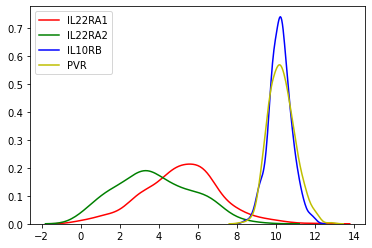

In [12]:
# filtering out non primary tumor samples (e.g. Cellines, healthy tissue, metastases)
df_clean = df.loc[df["sample_type"]== "Primary Tumor"] 

# Create a dataframe with only the gene expression data for further processing
X = df_clean.loc[:, df_clean.dtypes==np.float64].copy() 

# plotting the densities of the log2+1 gene expression counts
fig = sns.kdeplot(df_clean["IL22RA1"], color="r")
fig = sns.kdeplot(df_clean["IL22RA2"], color="g")
fig = sns.kdeplot(df_clean["IL10RB"], color="b")
fig = sns.kdeplot(df_clean["PVR"], color="y")
plt.show()

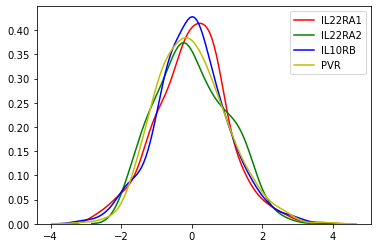

In [13]:

# Scaling the gene expression data 

scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)

X_scaled =  pd.DataFrame(X_scaled, index = X.index, columns = X.columns)


# density plots of the scaled dataset

fig = sns.kdeplot(X_scaled["IL22RA1"], color="r")
fig = sns.kdeplot(X_scaled["IL22RA2"], color="g")
fig = sns.kdeplot(X_scaled["IL10RB"], color="b")
fig = sns.kdeplot(X_scaled["PVR"], color="y")
plt.show()

## Dimensionality Reduction and Clustering

We chose t-distributed nearest neighbour embedding (t-SNE) as our method of dimensionality reduction. 
Following this, we used an agglomerative clustering algorithm to visualize the clustering of the cohort. By examining the dendrogram, we chose to fit three clusters to the dataset (Fig. 7A). A two dimensional visualisation of the dimensionality reduced data with the fit clusters can be seen in the dotplot (Fig. 7B).
We used the [agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) method of [sklearn](https://scikit-learn.org/stable/index.html) and the [hierarchical clustering](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) from [scipy](https://scipy.org/).

In [14]:
#TSNE dimensionality reduction

tsne = TSNE(n_components=2, perplexity = 20)
tsne_results = tsne.fit_transform(X_scaled).copy()
print(tsne_results)
df_TSNE = pd.DataFrame(tsne_results)
df_TSNE.columns = ['D1', 'D2'] 

[[-23.683533 -16.120573]
 [-22.863293 -17.456947]
 [-22.992983 -18.374819]
 ...
 [  5.446231  32.24433 ]
 [ -3.457935  26.072683]
 [ -4.708316  37.244843]]


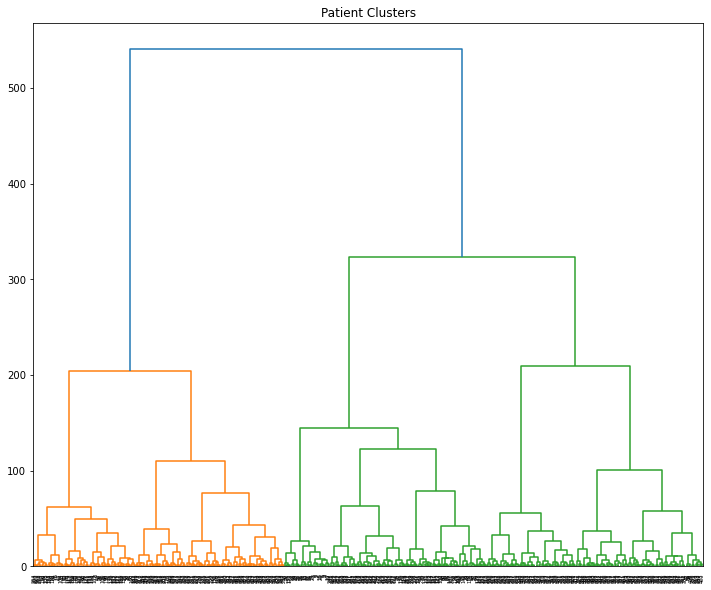

In [15]:
#dendrogram visulization of linkage of tsne reduced data

plt.figure(figsize =(12, 10)) 
plt.title('Patient Clusters') 

Dendrogram = shc.dendrogram((shc.linkage(df_TSNE, method ='ward')))
plt.savefig(fname = "LUAD_TSNE_Dendro_plt_perp20.svg", format = "svg")

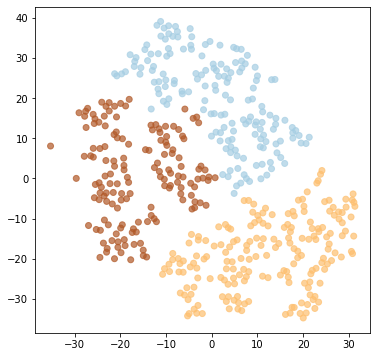

In [16]:
# Visualizing the clustering of tsne reduced data, n clusters was determined after examination of the dendrogram

ac = AgglomerativeClustering(n_clusters = 3) 
fig = plt.figure(figsize = (6,6))
plt.scatter(df_TSNE["D1"], df_TSNE["D2"], 
           c = ac.fit_predict(df_TSNE), cmap = "Paired", alpha = 0.7)
plt.savefig(fname = "LUAD_TSNE_2D_plt_perp20.svg", format = "svg")

## General Properties of the Clusters

By joining the cluster labels with the scaled high dimensional gene expression data, we were able to evaluate, whether the clustering resulted in distinct gene expression patterns. We plotted a heatmap, displaying the mean count of each gene per cluster (Fig. C). We then proceeded to analyze the proportion of each cluster within the LUAD cohort, which is visualized in the pie chart below (Fig. 7D).


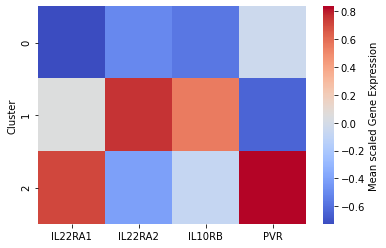

In [18]:
# Reassigning the patient codes to the TSNE transformed data, 
# fitting the cluster algorithm to the indexed data, and joining the predicted clusters with the scaled gene expression dataset

df_TSNE_ind = df_TSNE.set_index(X.index)
df_TSNE_ind["Cluster"] = ac.fit_predict(df_TSNE_ind)
df_clusters_tsne = X_scaled.join(df_TSNE_ind["Cluster"])

#Plotting the mean expression of each gene per cluster
cluster_means_tsne = df_clusters_tsne.groupby("Cluster").mean()
sns.heatmap(cluster_means_tsne, cmap= "coolwarm", cbar_kws = {"label":"Mean scaled Gene Expression"})
plt.savefig(fname = "LUAD_Cluster_Means_perp20.svg", format = "svg")


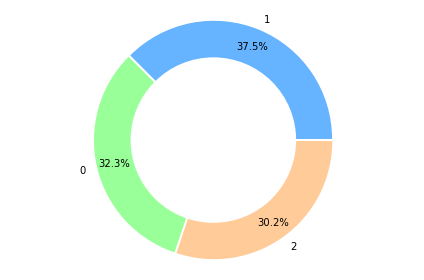

In [19]:
# Proportions of the clusters within the cohort
data = df_clusters_tsne["Cluster"].value_counts(normalize = True)*100
labels = data.index
explode = (0.01, 0.01, 0.01)
colors = ["#66b3ff", "#99ff99", "#ffcc99"]

fig1, ax1 = plt.subplots()
ax1.pie(data, labels = labels, explode = explode, colors = colors, pctdistance = 0.85, autopct="%1.1f%%")

centre_circle = plt.Circle((0,0), 0.7, fc ="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis("equal")
plt.tight_layout()
plt.savefig(fname = "LUAD_cluster_props_perp20.svg", format = "svg")
plt.show()


In [23]:
# create a dataframe containing genetic, phenotypic and cluster information for further analyses

df_pc = df_clean.join(df_clusters_tsne ["Cluster"])
df_pc

,samples,IL22RA1,IL22RA2,IL10RB,PVR,OS,OS.time,pathologic_stage,histological_type,sample_type,Cluster
sample,,,,,,,,,,,
TCGA-78-7540-01,TCGA-78-7540-01,12.11,2.109,10.680,11.130,1,1197,Stage IB,Lung Bronchioloalveolar Carcinoma Mucinous,Primary Tumor,2
TCGA-55-7284-01,TCGA-55-7284-01,10.99,2.245,10.540,10.410,1,243,Stage IIB,Lung Bronchioloalveolar Carcinoma Nonmucinous,Primary Tumor,2
TCGA-49-6742-01,TCGA-49-6742-01,10.34,1.695,10.500,10.120,1,488,Stage IIA,Mucinous (Colloid) Carcinoma,Primary Tumor,2
TCGA-44-6146-01,TCGA-44-6146-01,10.24,0.000,11.130,9.956,0,728,Stage IIB,Lung Mucinous Adenocarcinoma,Primary Tumor,2
TCGA-55-7728-01,TCGA-55-7728-01,10.22,4.491,10.690,9.954,0,704,Stage IB,Mucinous (Colloid) Carcinoma,Primary Tumor,2
...,...,...,...,...,...,...,...,...,...,...,...
TCGA-91-6828-01,TCGA-91-6828-01,0.00,5.687,9.739,10.070,0,323,Stage IA,Lung Adenocarcinoma- Not Otherwise Specified (...,Primary Tumor,0
TCGA-55-7815-01,TCGA-55-7815-01,0.00,5.647,9.696,10.760,0,773,Stage IB,Lung Adenocarcinoma- Not Otherwise Specified (...,Primary Tumor,0
TCGA-55-A48Y-01,TCGA-55-A48Y-01,0.00,4.494,9.649,10.880,0,630,Stage IIA,Lung Adenocarcinoma- Not Otherwise Specified (...,Primary Tumor,0


## Survival Analysis

We used the Kaplan Meier model to asess whether the gene expression patterns correlate with different survival outcomes of LUAD patients. The overview plot was used for Fig. 7E. We used the [Lifelines Library](https://lifelines.readthedocs.io/en/latest/) for our survival analysis.

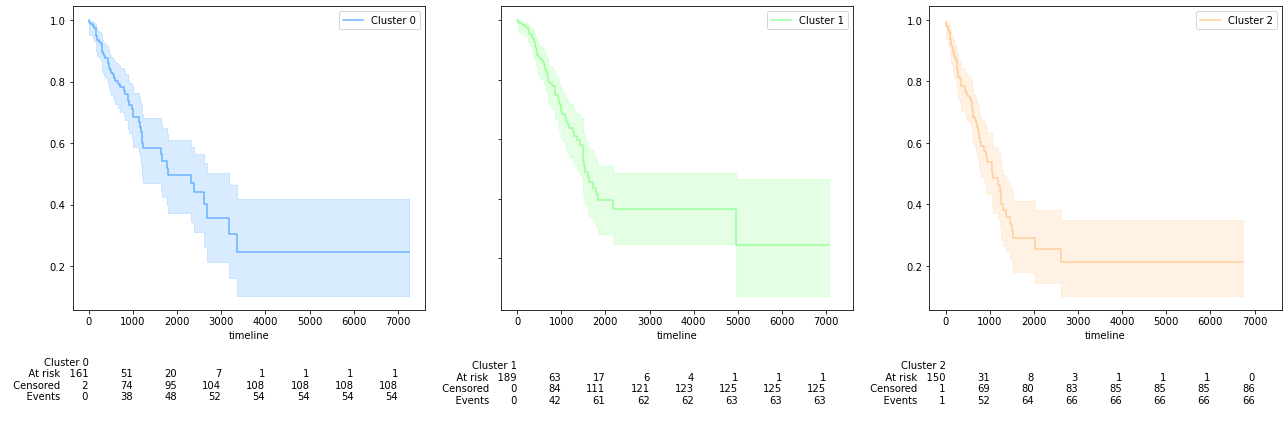

In [24]:
#Survival analysis 

from lifelines import KaplanMeierFitter
T = df_pc["OS.time"]
E = df_pc["OS"]
kmf = KaplanMeierFitter()
clusters = df_pc["Cluster"]
cl0 = (clusters == 0)
cl1 = (clusters == 1) 
cl2 = (clusters == 2)


#plotting kaplan meier plots for each cluster seperately for enhanced visibility

fig, (ax0, ax1, ax2) = plt.subplots(nrows = 1, ncols = 3, sharex = True, figsize = (20,20))

kmf= KaplanMeierFitter()
ax0 = kmf.fit(T[cl0], E[cl0], label="Cluster 0").plot(ax=ax0, figsize = (18, 6), at_risk_counts = True, color = "#66b3ff")
ax1 = kmf.fit(T[cl1], E[cl1], label="Cluster 1").plot(ax=ax1, figsize = (18, 6), at_risk_counts = True, color = "#99ff99")
ax2 = kmf.fit(T[cl2], E[cl2], label="Cluster 2").plot(ax=ax2, figsize = (18, 6), at_risk_counts = True, color = "#ffcc99")

plt.savefig(fname = "LUAD_SurvivalbyCluster.svg", format = "svg")
plt.tight_layout()

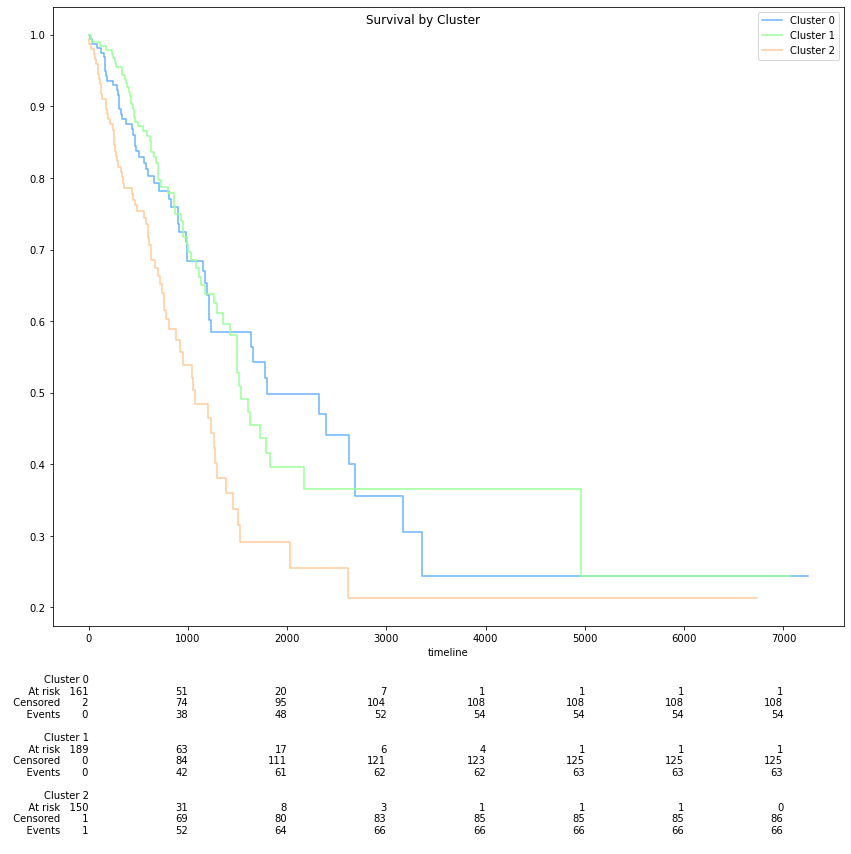

In [25]:
#plotting summary of all kaplan meier plots without confidence intervals to avoid overcrowding of the plot

fig, (ax) = plt.subplots(nrows = 1, ncols = 1, sharex = True, figsize = (12, 12))

kmf0= KaplanMeierFitter()
ax = kmf0.fit(T[cl0], E[cl0], label="Cluster 0").plot(ax=ax, figsize = (12, 12), ci_show = False, color = "#66b3ff")

kmf1= KaplanMeierFitter()
ax = kmf1.fit(T[cl1], E[cl1], label="Cluster 1").plot(ax=ax, figsize = (12, 12), ci_show = False, color = "#99ff99")

kmf2= KaplanMeierFitter()
ax = kmf2.fit(T[cl2], E[cl2], label="Cluster 2").plot(ax=ax, figsize = (12, 12), ci_show = False, color = "#ffcc99")

                                                      
from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf0, kmf1, kmf2, ax=ax)

fig.suptitle("Survival by Cluster")
plt.savefig(fname = "LUAD_SurvivalbyCluster_summary.svg", format = "svg")
plt.tight_layout()




### RMST

We used the restricted mean survival time ([RMST](https://lifelines.readthedocs.io/en/latest/Examples.html)) to assess the survival differences (delta RMST) between the clusters. A selection of this analysis can be found in Fig. 7F. we decided to set the time limit to five years.  "RMST is the average time free from an event up until a milestone time point, 
a numeric expression of the area under the Kaplan-Meier survival curve [...]. The comparison of RMSTs between treatment groups, 
the RMST difference (ΔRMST), is the mean absolute difference of event-free time associated with a therapy." [(Perego et. al. 2020)](https://doi.org/10.1016/j.jchf.2020.07.005), or in this case the gene expression cluster.



In [19]:
#RMST (Restricted mean survival time)

from lifelines.utils import restricted_mean_survival_time
time_limit = 1825 

kmf_0 = kmf0.fit(T[cl0], E[cl0], label="Cluster 0")
rmst_0 = restricted_mean_survival_time(kmf_0, t=time_limit)

kmf_1 = kmf1.fit(T[cl1], E[cl1], label="Cluster 1")
rmst_1 = restricted_mean_survival_time(kmf_1, t=time_limit)

kmf_2 = kmf2.fit(T[cl2], E[cl2], label="Cluster 2")
rmst_2 = restricted_mean_survival_time(kmf_2, t=time_limit)



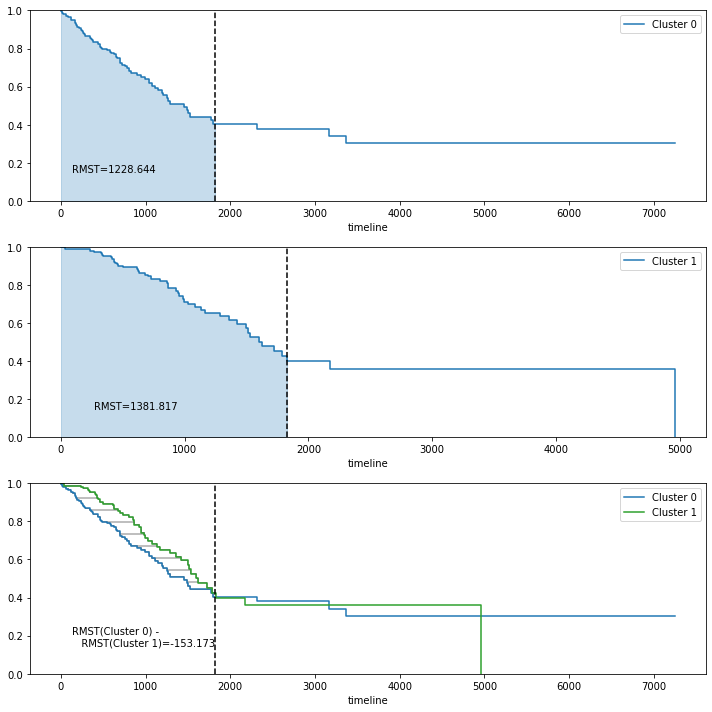

In [20]:
#Plotting the delta of RMSTs of Cluster 0  vs. Cluster 1 

from lifelines.plotting import rmst_plot

ax = plt.subplot(311)
rmst_plot(kmf_0, t=time_limit, ax=ax, figsize = (10,10))


ax = plt.subplot(312)
rmst_plot(kmf_1, t=time_limit, ax=ax, figsize = (10,10))


ax = plt.subplot(313)
rmst_plot(kmf_0, model2=kmf_1, t=time_limit, ax=ax, figsize = (10,10))

plt.savefig(fname = "LUAD_Cl0vs1_RMST_perp20.svg", format = "svg")

plt.tight_layout()



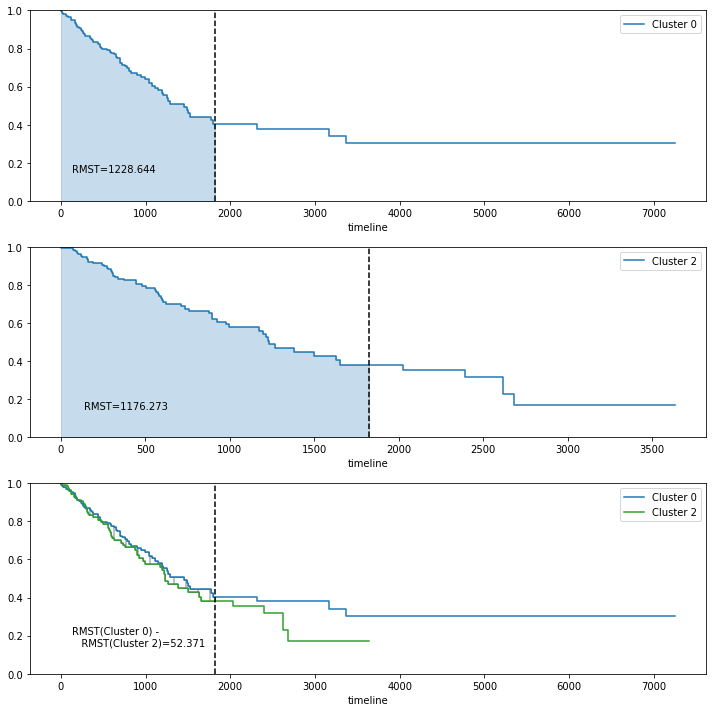

In [21]:
#Plotting the delta of RMSTs of Cluster 0 vs. Cluster 2

from lifelines.plotting import rmst_plot

ax = plt.subplot(311)
rmst_plot(kmf_0, t=time_limit, ax=ax, figsize = (10,10))


ax = plt.subplot(312)
rmst_plot(kmf_2, t=time_limit, ax=ax, figsize = (10,10))


ax = plt.subplot(313)
rmst_plot(kmf_0, model2=kmf_2, t=time_limit, ax=ax, figsize = (10,10))

plt.savefig(fname = "LUAD_Cl0vs2_RMST_perp20.svg", format = "svg")

plt.tight_layout()


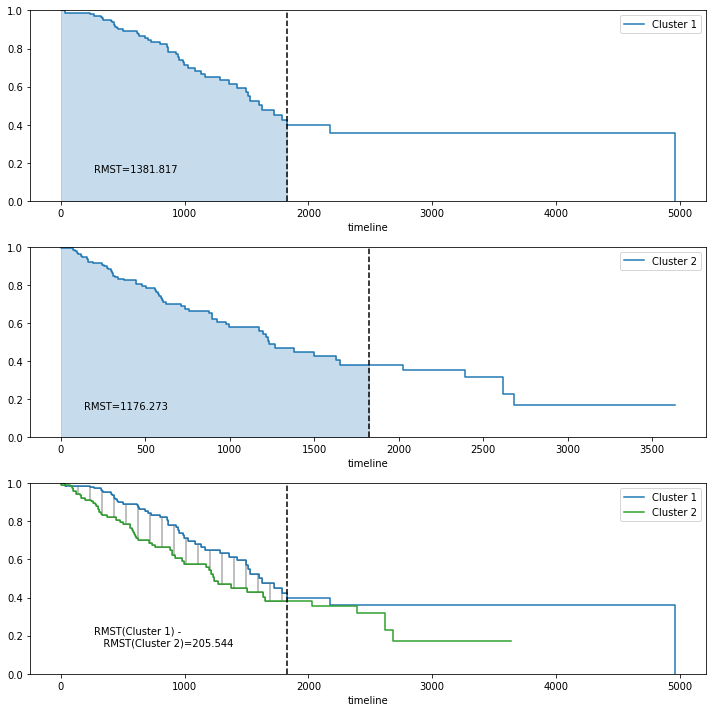

In [22]:
#Plotting the delta of RMSTs of Cluster 1 vs. Cluster 2

from lifelines.plotting import rmst_plot

ax = plt.subplot(311)
rmst_plot(kmf_1, t=time_limit, ax=ax, figsize = (10,10))


ax = plt.subplot(312)
rmst_plot(kmf_2, t=time_limit, ax=ax, figsize = (10,10))


ax = plt.subplot(313)
rmst_plot(kmf_1, model2=kmf_2, t=time_limit, ax=ax, figsize = (10,10))

plt.savefig(fname = "LUAD_Cl1vs2_RMST_perp20.svg", format = "svg")

plt.tight_layout()


## Statistical Testing of the Survival Curves

We chose the [log rank test](https://lifelines.readthedocs.io/en/latest/Examples.html) to test whether the survival curves differ significantly from one another. Here, the p-values for Fig. 7E were calculated.

In [23]:
# logrank test of cluster 0 vs. cluster 1
from lifelines.statistics import logrank_test

results = logrank_test(T[cl0], T[cl1], E[cl0], E[cl1 ], alpha=.95)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.58 0.11      3.21

In [24]:
# logrank test of cluster 0 vs. cluster 2
from lifelines.statistics import logrank_test

results = logrank_test(T[cl0], T[cl2], E[cl0], E[cl2], alpha=.95)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.03 0.31      1.69

In [25]:
# logrank test of cluster 1 vs. cluster 2
from lifelines.statistics import logrank_test

results = logrank_test(T[cl1], T[cl2], E[cl1], E[cl2], alpha=.95)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.82 0.02      5.98

## Cox Proportional Hazards Model

To see the impact of each gene of our IL-22 signature, we applied the [cox proportional hazards model](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html) (CoxPH). In a first step, we create a dataframe containing the scaled gene expression counts, the observation and the survival event information as an appropriate input for the model. The results of this analysis can be found in Fig. S1.


In [1]:
#create a dataframe as input for the CoxPH model

df_cox = X_scaled.join(df_pc["OS"])
df_cox_surv =df_cox.join(df_pc["OS.time"])
df_cox_surv

NameError: name 'X_scaled' is not defined

<lifelines.CoxPHFitter: fitted with 504 total observations, 321 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
      baseline estimation = breslow
   number of observations = 504
number of events observed = 183
   partial log-likelihood = -966.46
         time fit was run = 2022-04-04 20:33:32 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
IL22RA1     0.21       1.23       0.08             0.06             0.36                 1.06                 1.43
IL22RA2    -0.08       0.92       0.08            -0.23             0.08                 0.79                 1.08
IL10RB      0.08       1.08       0.08            -0.08             0.23                 0.93                 1.26
PVR         0.25       1.28       0.07             0.11             0.39                 1.11                 1.48

            cmp to     z      p   -log2(p)
covariate                                 
IL22RA1       0.00  2.72   0.01       7.26
IL22RA2       0.00 -1.00   0.32       1.65
IL10RB        0.00  1.00   0.32       1.66
PVR           0.00  3.47 <0.005      10.91
---
Concordance = 0.61
Partial AIC = 1940.93
log-likelihood ratio test = 23.26 on 4 df
-log2(p) of ll-ratio test = 13.12

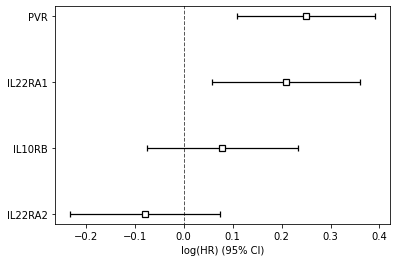

In [28]:
# Using Cox Proportional Hazards model to see the impact of each gene on survival 

from lifelines import CoxPHFitter


cph = CoxPHFitter()
cph.fit(df_cox_surv, duration_col = "OS.time", event_col='OS')
cph.print_summary()
cph.plot()
plt.savefig(fname = "LUAD_CoxPH_genes_perp20.svg", format = "svg")

## Clinical Phenotype

To see the clinical impact of the gene signatures, we analyzed the prevalence of pathological cancer stages among the clusters. In a first step, we summarized stae subtypes (e.g. IIA and IIB) to the main stage (e.g. Stage II). We then created dataframes containing the relative proportion of each stage per cluster as input for the pie charts, which can be found in Fig. 7F.

In [30]:
#summary of substages

df_pc["pathologic_stage"] = df_pc["pathologic_stage"].replace({"Stage IA": "Stage I", "Stage IB": "Stage I", "Stage IIA": "Stage II", "Stage IIB": "Stage II",
                                                              "Stage IIIA": "Stage III", "Stage IIIB": "Stage III"})
df_pc["pathologic_stage"].value_counts()


Stage I          270
Stage II         120
Stage III         81
Stage IV          26
[Discrepancy]      7
Name: pathologic_stage, dtype: int64

In [31]:
#removal of non essential information for the pie charts
df_stage_cl = df_pc.drop(["IL22RA1", "IL22RA2", "samples", "IL10RB", "PVR", "histological_type", "sample_type", "OS", "OS.time"], axis =1)
df_stage_cl

In [33]:
#calculating the relative proportions of each cancer stage per cluster

df_cl_0 = df_stage_cl.loc[df_stage_cl["Cluster"]==0]
df_cl_1 = df_stage_cl.loc[df_stage_cl["Cluster"]==1]
df_cl_2 = df_stage_cl.loc[df_stage_cl["Cluster"]==2]

data_sc_0 = pd.DataFrame(df_cl_0.groupby("Cluster")["pathologic_stage"].value_counts(normalize = True)*100)
data_sc_1 = pd.DataFrame(df_cl_1.groupby("Cluster")["pathologic_stage"].value_counts(normalize = True)*100)
data_sc_2 = pd.DataFrame(df_cl_2.groupby("Cluster")["pathologic_stage"].value_counts(normalize = True)*100)

data_sc_0.reset_index(level=0, drop=True, inplace = True)
data_sc_1.reset_index(level=0, drop=True, inplace = True)
data_sc_2.reset_index(level=0, drop=True, inplace = True)

data_sc_0.sort_index(inplace = True)
data_sc_1.sort_index(inplace = True)
data_sc_2.sort_index(inplace = True)


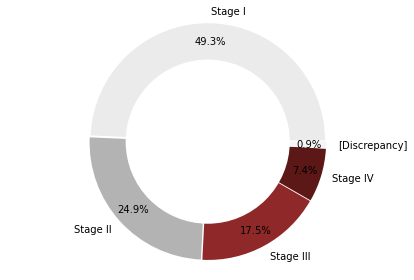

In [37]:
#Proportions of stages within cluster 0
data = data_sc_0.squeeze()
labels = data_sc_0.index

explode = [0.01 for record in data]

colors = ["#ebebeb", "#b3b3b3", "#8f2929", "#5c1717", "#f5f5f5"]

fig1, ax1 = plt.subplots()
ax1.pie(data, labels = labels, explode = explode, colors = colors, pctdistance = 0.85, autopct="%1.1f%%")

centre_circle = plt.Circle((0,0), 0.7, fc ="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis("equal")
plt.tight_layout()
plt.savefig(fname = "LUAD_Cl0_stages_perp20.svg", format = "svg")
plt.show()

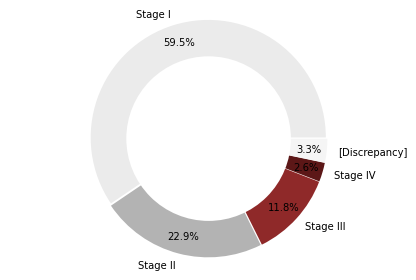

In [38]:
#Proportions of stages within cluster 1
data = data_sc_1.squeeze()
labels = data_sc_1.index
explode = [0.01 for record in data]
colors = ["#ebebeb", "#b3b3b3", "#8f2929", "#5c1717", "#f5f5f5"]

fig1, ax1 = plt.subplots()
ax1.pie(data, labels = labels, explode = explode, colors = colors, pctdistance = 0.85, autopct="%1.1f%%")

centre_circle = plt.Circle((0,0), 0.7, fc ="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis("equal")
plt.tight_layout()
plt.savefig(fname = "LUAD_Cl1_stages_perp20.svg", format = "svg")
plt.show()


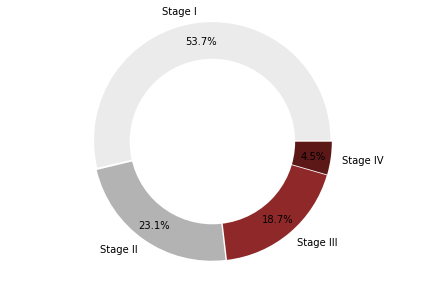

In [39]:
#Proportions of stages within cluster 2
data = data_sc_2.squeeze()
labels = data_sc_2.index
explode = [0.01 for record in data]
colors = ["#ebebeb", "#b3b3b3", "#8f2929", "#5c1717"]

fig1, ax1 = plt.subplots()
ax1.pie(data, labels = labels, explode = explode, colors = colors, pctdistance = 0.85, autopct="%1.1f%%")

centre_circle = plt.Circle((0,0), 0.7, fc ="white")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis("equal")
plt.tight_layout()
plt.savefig(fname = "LUAD_Cl2_stages_perp20.svg", format = "svg")
plt.show()

In [41]:
#export a summary of the absolute counts of each stage per cluster
summary = pd.DataFrame(df_stage_cl.groupby("Cluster")["pathologic_stage"].value_counts())
summary.to_excel("LUAD_abs_stage_counts.xlsx")